# 📅 Calendar Hub - Guide Complet d'Utilisation

Ce notebook présente des exemples concrets d'utilisation du package `calendar_hub` pour gérer les jours fériés et jours ouvrés à travers différentes sources:
- **Exchanges** (bourses via `exchange-calendars`)
- **Countries** (pays via `workalendar`)
- **RFR** (taux sans risque via `QuantLib`)

## 📦 Installation

```bash
pip install exchange-calendars workalendar QuantLib
```

In [6]:
from better_calendar import BetterCalendar, UnknownExchangeError, UnknownCountryError, UnknownRfrError
from datetime import date, timedelta
import pandas as pd

# Initialisation du hub principal
hub = BetterCalendar.default()

print("✅ CalendarHub initialisé avec succès")

✅ CalendarHub initialisé avec succès


## 1️⃣ Calendriers de Bourses (Exchanges)

Les calendriers d'exchanges reflètent les **sessions de trading réelles** avec leurs jours de fermeture.

### Exemple 1.1: Jours de fermeture de la Bourse de Paris (XPAR)

In [7]:
# Récupérer l'adaptateur pour Euronext Paris
xpar = hub.get_from_exchange("XPAR")

# Période d'analyse
start = date(2026, 1, 1)
end = date(2026, 1, 31)

# Jours de fermeture (OFF)
off_days = xpar.holidays(start, end)
print(f"📊 XPAR - Jours de fermeture en janvier 2026: {len(off_days)} jours\n")

# Afficher les 10 premiers
for day in off_days[:10]:
    day_name = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'][day.weekday()]
    print(f"  {day.strftime('%Y-%m-%d')} ({day_name})")

📊 XPAR - Jours de fermeture en janvier 2026: 10 jours

  2026-01-01 (Jeu)
  2026-01-03 (Sam)
  2026-01-04 (Dim)
  2026-01-10 (Sam)
  2026-01-11 (Dim)
  2026-01-17 (Sam)
  2026-01-18 (Dim)
  2026-01-24 (Sam)
  2026-01-25 (Dim)
  2026-01-31 (Sam)


### Exemple 1.2: Comparer plusieurs bourses

In [8]:
# Comparer Paris, New York et Londres
exchanges = {
    "Paris (XPAR)": "XPAR",
    "New York (XNYS)": "XNYS",
    "Londres (XLON)": "XLON"
}

start = date(2026, 12, 20)
end = date(2026, 12, 31)

print("🌍 Comparaison des fermetures de fin d'année 2026:\n")

for name, code in exchanges.items():
    cal = hub.get_from_exchange(code)
    off = cal.holidays(start, end)
    bdays = cal.business_days(start, end)
    print(f"{name}:")
    print(f"  • Jours fermés: {len(off)}")
    print(f"  • Jours ouvrés: {len(bdays)}")
    print()

🌍 Comparaison des fermetures de fin d'année 2026:

Paris (XPAR):
  • Jours fermés: 4
  • Jours ouvrés: 8

New York (XNYS):
  • Jours fermés: 4
  • Jours ouvrés: 8

Londres (XLON):
  • Jours fermés: 5
  • Jours ouvrés: 7



### Exemple 1.3: Vérifier si un jour spécifique est ouvré

In [9]:
# Tester plusieurs dates
test_dates = [
    date(2026, 1, 1),   # Jour de l'an
    date(2026, 1, 2),   # Vendredi après jour de l'an
    date(2026, 1, 3),   # Samedi
    date(2026, 1, 5),   # Lundi normal
]

xpar = hub.get_from_rfr("SOFRRATE Index")

print("🔍 Test de jours ouvrés sur XPAR:\n")
for d in test_dates:
    is_bday = xpar.is_business_day(d)
    status = "✅ OUVERT" if is_bday else "🚫 FERMÉ"
    day_name = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'][d.weekday()]
    print(f"{d.strftime('%Y-%m-%d')} ({day_name}): {status}")

🔍 Test de jours ouvrés sur XPAR:

2026-01-01 (Jeu): 🚫 FERMÉ
2026-01-02 (Ven): ✅ OUVERT
2026-01-03 (Sam): 🚫 FERMÉ
2026-01-05 (Lun): ✅ OUVERT


### Exemple 1.4: Gestion des erreurs - Exchange inconnu

In [10]:
# Tenter d'accéder à un exchange qui n'existe pas
try:
    invalid_exchange = hub.get_from_exchange("XXXX")
    print("Pas d'erreur levée (problème!)")
except UnknownExchangeError as e:
    print(f"✅ Exception attendue capturée: {e}")

✅ Exception attendue capturée: Unknown/unsupported exchange code: 'XXXX'


## 2️⃣ Calendriers de Pays (Countries)

Les calendriers de pays incluent les **jours fériés légaux** et les week-ends.

### Exemple 2.1: Jours fériés en France

In [11]:
fr = hub.get_from_country("FR")

# Tous les jours OFF sur une année
start = date(2026, 1, 1)
end = date(2026, 12, 31)

off_days = fr.holidays(start, end)
business_days = fr.business_days(start, end)

print(f"🇫🇷 France - Année 2026:")
print(f"  • Total jours: 365")
print(f"  • Jours OFF (fériés + week-ends): {len(off_days)}")
print(f"  • Jours ouvrés: {len(business_days)}")
print(f"  • Ratio ouvrés: {len(business_days)/365*100:.1f}%")

🇫🇷 France - Année 2026:
  • Total jours: 365
  • Jours OFF (fériés + week-ends): 113
  • Jours ouvrés: 252
  • Ratio ouvrés: 69.0%


### Exemple 2.2: Identifier les jours fériés spécifiques (hors week-ends)

In [12]:
# Filtrer uniquement les jours fériés en semaine
start = date(2026, 1, 1)
end = date(2026, 12, 31)

fr = hub.get_from_country("FR")
all_off = fr.holidays(start, end)

# Filtrer les jours fériés qui tombent en semaine
weekday_holidays = [d for d in all_off if d.weekday() < 5]

print(f"🎉 Jours fériés en semaine en France (2026): {len(weekday_holidays)} jours\n")

for holiday in weekday_holidays:
    day_name = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven'][holiday.weekday()]
    print(f"  {holiday.strftime('%Y-%m-%d')} ({day_name})")

🎉 Jours fériés en semaine en France (2026): 9 jours

  2026-01-01 (Jeu)
  2026-04-06 (Lun)
  2026-05-01 (Ven)
  2026-05-08 (Ven)
  2026-05-14 (Jeu)
  2026-05-25 (Lun)
  2026-07-14 (Mar)
  2026-11-11 (Mer)
  2026-12-25 (Ven)


### Exemple 2.3: Comparer plusieurs pays

In [13]:
countries = {
    "🇫🇷 France": "FR",
    "🇺🇸 USA": "US",
    "🇬🇧 UK": "GB",
    "🇩🇪 Allemagne": "DE",
    "🇯🇵 Japon": "JP"
}

start = date(2026, 1, 1)
end = date(2026, 12, 31)

print("🌍 Comparaison internationale - Année 2026:\n")

results = []
for name, code in countries.items():
    cal = hub.get_from_country(code)
    off = cal.holidays(start, end)
    bdays = cal.business_days(start, end)
    weekday_holidays = [d for d in off if d.weekday() < 5]
    
    results.append({
        "Pays": name,
        "Jours ouvrés": len(bdays),
        "Jours OFF": len(off),
        "Fériés en semaine": len(weekday_holidays)
    })

df = pd.DataFrame(results)
print(df.to_string(index=False))

🌍 Comparaison internationale - Année 2026:

        Pays  Jours ouvrés  Jours OFF  Fériés en semaine
   🇫🇷 France           252        113                  9
      🇺🇸 USA           251        114                 10
       🇬🇧 UK           253        112                  8
🇩🇪 Allemagne           254        111                  7
    🇯🇵 Japon           246        119                 15


### Exemple 2.4: Gestion des erreurs - Pays inconnu

In [14]:
try:
    invalid_country = hub.get_from_country("ZZ")
    print("Pas d'erreur levée (problème!)")
except UnknownCountryError as e:
    print(f"✅ Exception attendue capturée: {e}")

✅ Exception attendue capturée: Unknown/unsupported country ISO code in workalendar: 'ZZ'


## 3️⃣ Calendriers RFR (Risk-Free Rates)

Les calendriers RFR utilisent les conventions de **jours ouvrés pour les taux de référence** (€STR, SOFR, SONIA...).

### Exemple 3.1: €STR (Euro Short-Term Rate) - TARGET

In [15]:
# €STR utilise le calendrier TARGET (Trans-European Automated Real-time Gross Settlement)
estr = hub.get_from_rfr("ESTRON Index")

start = date(2026, 1, 1)
end = date(2026, 1, 31)

off_days = estr.holidays(start, end)
business_days = estr.business_days(start, end)

print(f"💶 €STR (TARGET) - Janvier 2026:")
print(f"  • Jours OFF: {len(off_days)}")
print(f"  • Jours ouvrés: {len(business_days)}")
print(f"\nPremiers jours OFF:")
for day in off_days[:10]:
    day_name = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'][day.weekday()]
    print(f"  {day.strftime('%Y-%m-%d')} ({day_name})")

💶 €STR (TARGET) - Janvier 2026:
  • Jours OFF: 10
  • Jours ouvrés: 21

Premiers jours OFF:
  2026-01-01 (Jeu)
  2026-01-03 (Sam)
  2026-01-04 (Dim)
  2026-01-10 (Sam)
  2026-01-11 (Dim)
  2026-01-17 (Sam)
  2026-01-18 (Dim)
  2026-01-24 (Sam)
  2026-01-25 (Dim)
  2026-01-31 (Sam)


### Exemple 3.2: SOFR (Secured Overnight Financing Rate) - US

In [16]:
# SOFR utilise le calendrier US Government Bond
sofr = hub.get_from_rfr("SOFRRATE Index")

start = date(2026, 1, 1)
end = date(2026, 1, 31)

off_days = sofr.holidays(start, end)
business_days = sofr.business_days(start, end)

print(f"💵 SOFR (US Gov Bonds) - Janvier 2026:")
print(f"  • Jours OFF: {len(off_days)}")
print(f"  • Jours ouvrés: {len(business_days)}")
print(f"\nPremiers jours OFF:")
for day in off_days[:10]:
    day_name = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'][day.weekday()]
    print(f"  {day.strftime('%Y-%m-%d')} ({day_name})")

💵 SOFR (US Gov Bonds) - Janvier 2026:
  • Jours OFF: 11
  • Jours ouvrés: 20

Premiers jours OFF:
  2026-01-01 (Jeu)
  2026-01-03 (Sam)
  2026-01-04 (Dim)
  2026-01-10 (Sam)
  2026-01-11 (Dim)
  2026-01-17 (Sam)
  2026-01-18 (Dim)
  2026-01-19 (Lun)
  2026-01-24 (Sam)
  2026-01-25 (Dim)


### Exemple 3.3: Comparer les RFR disponibles

In [17]:
# Lister les RFR supportés
supported_rfrs = hub.supported_rfrs()

print(f"📋 RFR disponibles ({len(supported_rfrs)}):")
for rfr in supported_rfrs:
    print(f"  • {rfr}")

📋 RFR disponibles (11):
  • ESTR
  • ESTR INDEX
  • ESTRON
  • ESTRON INDEX
  • SOFR
  • SOFR INDEX
  • SOFRRATE
  • SOFRRATE INDEX
  • SONIA
  • SONIA INDEX
  • SONIO/N INDEX


### Exemple 3.4: Variantes de notation pour €STR

In [18]:
# Le système normalise automatiquement les variantes
variants = [
    "ESTRON Index",
    "  estron   index  ",  # Espaces multiples
    "€STRON Index",        # Symbole €
    "ESTR Index",          # Forme courte
]

test_date = date(2026, 1, 1)

print("🔄 Test des variantes de notation pour €STR:\n")
for variant in variants:
    try:
        cal = hub.get_from_rfr(variant)
        is_bday = cal.is_business_day(test_date)
        print(f"✅ '{variant}' → {cal.name}")
    except Exception as e:
        print(f"❌ '{variant}' → Erreur: {e}")

🔄 Test des variantes de notation pour €STR:

✅ 'ESTRON Index' → rfr:ESTR(TARGET)
✅ '  estron   index  ' → rfr:ESTR(TARGET)
✅ '€STRON Index' → rfr:ESTR(TARGET)
✅ 'ESTR Index' → rfr:ESTR(TARGET)


## 4️⃣ API Unifiée - Utilisation Pratique

L'API unifiée permet d'utiliser n'importe quel calendrier avec la même interface.

### Exemple 4.1: Méthode `holidays()` unifiée

In [19]:
start = date(2026, 7, 1)
end = date(2026, 7, 31)

# Même interface pour tous les types de calendriers
off_exchange = hub.holidays("exchange", "XPAR", start, end)
off_country = hub.holidays("country", "FR", start, end)
off_rfr = hub.holidays("rfr", "ESTRON Index", start, end)

print(f"📅 Juillet 2026 - Comparaison des jours OFF:\n")
print(f"  • XPAR (exchange):  {len(off_exchange)} jours")
print(f"  • FR (country):     {len(off_country)} jours")
print(f"  • €STR (rfr):       {len(off_rfr)} jours")

📅 Juillet 2026 - Comparaison des jours OFF:

  • XPAR (exchange):  8 jours
  • FR (country):     9 jours
  • €STR (rfr):       8 jours


### Exemple 4.2: Calcul du prochain jour ouvré

In [20]:
# Partir d'un samedi
saturday = date(2026, 2, 13)

# Trouver le prochain jour ouvré selon différents calendriers
next_xpar = hub.next_business_day("exchange", "XPAR", saturday)
next_fr = hub.next_business_day("country", "FR", saturday)
next_estr = hub.next_business_day("rfr", "SOFRRATE Index", saturday)

print(f"🗓️  Date de départ: {saturday.strftime('%Y-%m-%d')} (Samedi)\n")
print(f"Prochain jour ouvré:")
print(f"  • XPAR (exchange):  {next_xpar.strftime('%Y-%m-%d')} ({['Lun', 'Mar', 'Mer', 'Jeu', 'Ven'][next_xpar.weekday()]})")
print(f"  • FR (country):     {next_fr.strftime('%Y-%m-%d')} ({['Lun', 'Mar', 'Mer', 'Jeu', 'Ven'][next_fr.weekday()]})")
print(f"  • SOFRRATE (rfr):   {next_estr.strftime('%Y-%m-%d')} ({['Lun', 'Mar', 'Mer', 'Jeu', 'Ven'][next_estr.weekday()]})")

🗓️  Date de départ: 2026-02-13 (Samedi)

Prochain jour ouvré:
  • XPAR (exchange):  2026-02-16 (Lun)
  • FR (country):     2026-02-16 (Lun)
  • SOFRRATE (rfr):   2026-02-17 (Mar)


### Exemple 4.3: Ajouter N jours ouvrés

In [21]:
# Date de départ
start_date = date(2026, 1, 5)  # Lundi

# Ajouter 10 jours ouvrés
n_days = 10

result_xpar = hub.add_business_days("exchange", "XPAR", start_date, n_days)
result_fr = hub.add_business_days("country", "FR", start_date, n_days)

print(f"📆 Ajouter {n_days} jours ouvrés à partir du {start_date.strftime('%Y-%m-%d')}:\n")
print(f"  • XPAR: {result_xpar.strftime('%Y-%m-%d')}")
print(f"  • FR:   {result_fr.strftime('%Y-%m-%d')}")

# Calculer le nombre de jours calendaires écoulés
calendar_days_xpar = (result_xpar - start_date).days
calendar_days_fr = (result_fr - start_date).days

print(f"\n  → XPAR: {calendar_days_xpar} jours calendaires pour {n_days} jours ouvrés")
print(f"  → FR:   {calendar_days_fr} jours calendaires pour {n_days} jours ouvrés")

📆 Ajouter 10 jours ouvrés à partir du 2026-01-05:

  • XPAR: 2026-01-19
  • FR:   2026-01-19

  → XPAR: 14 jours calendaires pour 10 jours ouvrés
  → FR:   14 jours calendaires pour 10 jours ouvrés


### Exemple 4.4: Jours ouvrés en arrière

In [22]:
# Date de fin
end_date = date(2026, 1, 31)

# Reculer de 5 jours ouvrés
n_days_back = -5

result = hub.add_business_days("country", "FR", end_date, n_days_back)

print(f"⏪ Reculer de 5 jours ouvrés depuis {end_date.strftime('%Y-%m-%d')}:")
print(f"  → {result.strftime('%Y-%m-%d')}")

# Vérifier avec prev_business_day (équivalent à -1)
prev = hub.prev_business_day("country", "FR", end_date)
print(f"\n⏪ Jour ouvré précédent: {prev.strftime('%Y-%m-%d')}")

⏪ Reculer de 5 jours ouvrés depuis 2026-01-31:
  → 2026-01-26

⏪ Jour ouvré précédent: 2026-01-30


## 5️⃣ Cas d'Usage Pratiques

Exemples de situations réelles où le package est utile.

### Cas 5.1: Calcul de settlement date (T+2)

In [23]:
# Trade exécuté un vendredi
trade_date = date(2026, 1, 2)  # Vendredi

# Settlement = T+2 jours ouvrés sur la bourse concernée
settlement_xpar = hub.add_business_days("exchange", "XPAR", trade_date, 2)
settlement_xnys = hub.add_business_days("exchange", "XNYS", trade_date, 2)

print(f"💼 Trade date: {trade_date.strftime('%Y-%m-%d')} (Vendredi)")
print(f"\nSettlement T+2:")
print(f"  • XPAR (Paris):    {settlement_xpar.strftime('%Y-%m-%d')}")
print(f"  • XNYS (New York): {settlement_xnys.strftime('%Y-%m-%d')}")

💼 Trade date: 2026-01-02 (Vendredi)

Settlement T+2:
  • XPAR (Paris):    2026-01-06
  • XNYS (New York): 2026-01-06


### Cas 5.2: Vérifier la disponibilité d'un fixing RFR

In [24]:
# Pour un swap €STR, vérifier si le fixing est disponible
dates_to_check = [
    date(2026, 1, 1),   # Jour de l'an
    date(2026, 1, 2),   # Vendredi normal
    date(2026, 1, 3),   # Samedi
    date(2026, 1, 5),   # Lundi
]

estr = hub.get_from_rfr("ESTRON Index")

print("📊 Disponibilité des fixings €STR:\n")
for d in dates_to_check:
    is_available = estr.is_business_day(d)
    status = "✅ Disponible" if is_available else "❌ Non disponible"
    day_name = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'][d.weekday()]
    print(f"{d.strftime('%Y-%m-%d')} ({day_name}): {status}")

📊 Disponibilité des fixings €STR:

2026-01-01 (Jeu): ❌ Non disponible
2026-01-02 (Ven): ✅ Disponible
2026-01-03 (Sam): ❌ Non disponible
2026-01-05 (Lun): ✅ Disponible


### Cas 5.3: Planifier des réunions inter-pays

In [25]:
# Trouver les jours où TOUS les pays travaillent
start = date(2026, 12, 20)
end = date(2026, 12, 31)

countries_codes = ["FR", "US", "GB", "DE"]
countries = {code: hub.get_from_country(code) for code in countries_codes}

# Jours ouvrés pour chaque pays
all_business_days = {}
for code, cal in countries.items():
    all_business_days[code] = set(cal.business_days(start, end))

# Intersection = jours où TOUS travaillent
common_days = set.intersection(*all_business_days.values())

print(f"🤝 Jours ouvrés communs (FR, US, GB, DE) du {start} au {end}:\n")
print(f"Total: {len(common_days)} jours\n")

for d in sorted(common_days):
    day_name = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven'][d.weekday()]
    print(f"  {d.strftime('%Y-%m-%d')} ({day_name})")

🤝 Jours ouvrés communs (FR, US, GB, DE) du 2026-12-20 au 2026-12-31:

Total: 7 jours

  2026-12-21 (Lun)
  2026-12-22 (Mar)
  2026-12-23 (Mer)
  2026-12-24 (Jeu)
  2026-12-29 (Mar)
  2026-12-30 (Mer)
  2026-12-31 (Jeu)


### Cas 5.4: Calculer des intérêts sur période

In [26]:
# Calcul d'intérêts sur base ACT/365 avec jours ouvrés
start = date(2026, 1, 1)
end = date(2026, 12, 31)

principal = 1_000_000  # 1M EUR
rate = 0.035  # 3.5%

# Selon calendrier TARGET pour €STR
estr = hub.get_from_rfr("ESTRON Index")
business_days = estr.business_days(start, end)
n_bdays = len(business_days)

# Intérêts
interest = principal * rate * n_bdays / 365

print(f"💰 Calcul d'intérêts (€STR/TARGET):")
print(f"  • Principal: {principal:,.0f} EUR")
print(f"  • Taux: {rate*100:.2f}%")
print(f"  • Période: {start} à {end}")
print(f"  • Jours ouvrés: {n_bdays}")
print(f"  • Intérêts: {interest:,.2f} EUR")

💰 Calcul d'intérêts (€STR/TARGET):
  • Principal: 1,000,000 EUR
  • Taux: 3.50%
  • Période: 2026-01-01 à 2026-12-31
  • Jours ouvrés: 256
  • Intérêts: 24,547.95 EUR


## 6️⃣ Visualisations

### Visualisation 6.1: Comparaison mensuelle des jours ouvrés

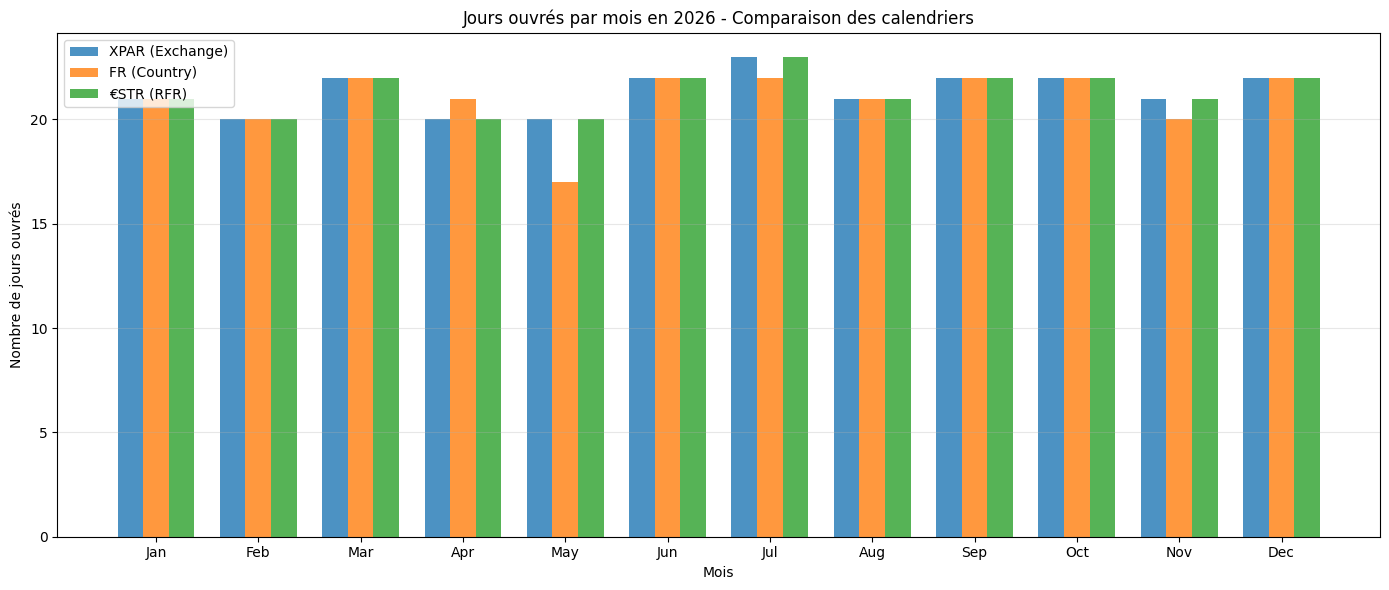


📊 Statistiques annuelles 2026:
XPAR    256
FR      252
€STR    256
dtype: int64


In [27]:
import matplotlib.pyplot as plt

# Analyser chaque mois de 2026
months_data = []

for month in range(1, 13):
    # Déterminer le dernier jour du mois
    if month == 12:
        month_end = date(2026, 12, 31)
    else:
        month_end = date(2026, month + 1, 1) - timedelta(days=1)
    
    month_start = date(2026, month, 1)
    
    # Calendriers
    xpar_bdays = len(hub.get_from_exchange("XPAR").business_days(month_start, month_end))
    fr_bdays = len(hub.get_from_country("FR").business_days(month_start, month_end))
    estr_bdays = len(hub.get_from_rfr("ESTRON Index").business_days(month_start, month_end))
    
    months_data.append({
        'Mois': month_start.strftime('%b'),
        'XPAR': xpar_bdays,
        'FR': fr_bdays,
        '€STR': estr_bdays
    })

df_months = pd.DataFrame(months_data)

# Graphique
fig, ax = plt.subplots(figsize=(14, 6))
x = range(len(df_months))
width = 0.25

ax.bar([i - width for i in x], df_months['XPAR'], width, label='XPAR (Exchange)', alpha=0.8)
ax.bar(x, df_months['FR'], width, label='FR (Country)', alpha=0.8)
ax.bar([i + width for i in x], df_months['€STR'], width, label='€STR (RFR)', alpha=0.8)

ax.set_xlabel('Mois')
ax.set_ylabel('Nombre de jours ouvrés')
ax.set_title('Jours ouvrés par mois en 2026 - Comparaison des calendriers')
ax.set_xticks(x)
ax.set_xticklabels(df_months['Mois'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Statistiques annuelles 2026:")
print(df_months[['XPAR', 'FR', '€STR']].sum())

### Visualisation 6.2: Heatmap des jours OFF

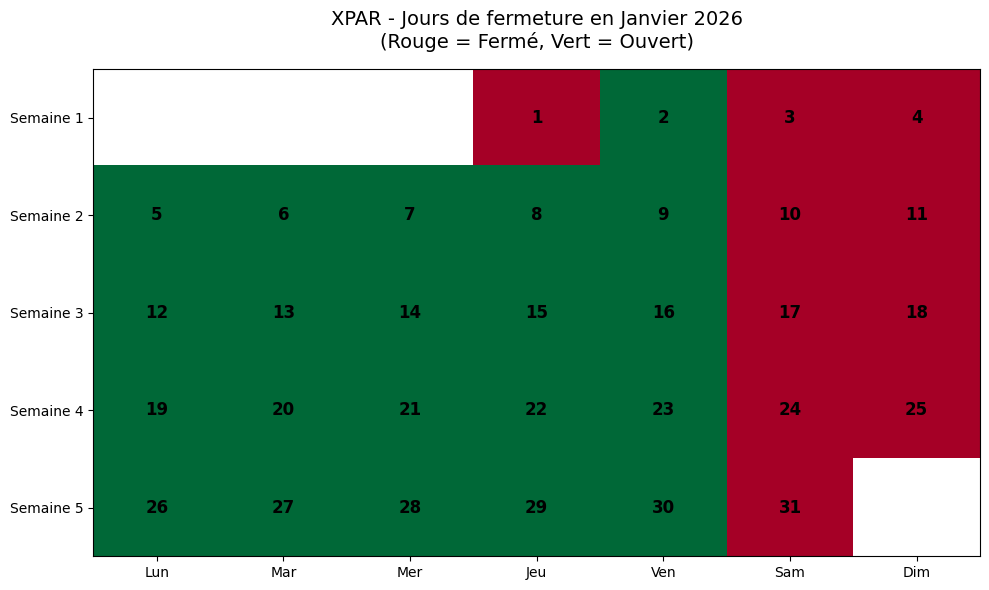

In [28]:
import numpy as np

# Créer une matrice pour janvier 2026
start = date(2026, 1, 1)
end = date(2026, 1, 31)

xpar = hub.get_from_exchange("XPAR")
off_dates = set(xpar.holidays(start, end))

# Créer la grille (semaines x jours)
calendar_grid = []
current = start
week = []

# Ajouter des jours vides au début si nécessaire
for _ in range(current.weekday()):
    week.append(None)

while current <= end:
    week.append(current)
    if len(week) == 7:
        calendar_grid.append(week)
        week = []
    current += timedelta(days=1)

# Compléter la dernière semaine
if week:
    while len(week) < 7:
        week.append(None)
    calendar_grid.append(week)

# Créer la matrice de valeurs (1 = OFF, 0 = ouvert)
matrix = []
for week in calendar_grid:
    week_values = []
    for day in week:
        if day is None:
            week_values.append(np.nan)
        elif day in off_dates:
            week_values.append(1)
        else:
            week_values.append(0)
    matrix.append(week_values)

# Visualisation
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=1)

# Axes
ax.set_xticks(range(7))
ax.set_xticklabels(['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'])
ax.set_yticks(range(len(calendar_grid)))
ax.set_yticklabels([f'Semaine {i+1}' for i in range(len(calendar_grid))])

# Ajouter les numéros de jours
for i, week in enumerate(calendar_grid):
    for j, day in enumerate(week):
        if day is not None:
            text = ax.text(j, i, day.day, ha="center", va="center", color="black", fontsize=12, weight='bold')

ax.set_title('XPAR - Jours de fermeture en Janvier 2026\n(Rouge = Fermé, Vert = Ouvert)', fontsize=14, pad=15)
plt.tight_layout()
plt.show()

## 7️⃣ Limites et Considérations

Points importants à connaître sur le package.

### Limite 7.1: Dépendances externes requises

In [29]:
# Vérifier les dépendances installées
dependencies = {
    'exchange-calendars': False,
    'workalendar': False,
    'QuantLib': False
}

try:
    import exchange_calendars
    dependencies['exchange-calendars'] = True
except:
    pass

try:
    import workalendar
    dependencies['workalendar'] = True
except:
    pass

try:
    import QuantLib
    dependencies['QuantLib'] = True
except:
    pass

print("📦 État des dépendances:\n")
for dep, installed in dependencies.items():
    status = "✅ Installé" if installed else "❌ Non installé"
    print(f"  {dep}: {status}")

print("\n⚠️ Note: Chaque type de calendrier nécessite sa dépendance correspondante:")
print("  • Exchanges → exchange-calendars")
print("  • Countries → workalendar")
print("  • RFRs → QuantLib")

📦 État des dépendances:

  exchange-calendars: ✅ Installé
  workalendar: ✅ Installé
  QuantLib: ✅ Installé

⚠️ Note: Chaque type de calendrier nécessite sa dépendance correspondante:
  • Exchanges → exchange-calendars
  • Countries → workalendar
  • RFRs → QuantLib


### Limite 7.2: Performance et cache

In [30]:
import time

# Test de performance avec cache
xpar = hub.get_from_exchange("XPAR")
start = date(2020, 1, 1)
end = date(2026, 12, 31)

# Premier appel (calcul)
t0 = time.time()
result1 = xpar.holidays(start, end)
t1 = time.time()
time_first = (t1 - t0) * 1000

# Deuxième appel (cache)
t0 = time.time()
result2 = xpar.holidays(start, end)
t1 = time.time()
time_cached = (t1 - t0) * 1000

print(f"⚡ Performance (période 2020-2026):")
print(f"  • Premier appel: {time_first:.2f} ms")
print(f"  • Appel avec cache: {time_cached:.2f} ms")
print(f"  • Speedup: {time_first/time_cached:.1f}x")
print(f"\n💡 Le cache LRU améliore les performances pour les requêtes répétées")

⚡ Performance (période 2020-2026):
  • Premier appel: 1.96 ms
  • Appel avec cache: 0.72 ms
  • Speedup: 2.7x

💡 Le cache LRU améliore les performances pour les requêtes répétées


### Limite 7.3: Exceptions et erreurs courantes

In [32]:
from better_calendar import MissingDependencyError, CalendarError

print("🚨 Types d'exceptions possibles:\n")

# 1. Exchange inconnu
try:
    hub.get_from_exchange("INVALID")
except UnknownExchangeError as e:
    print(f"1. UnknownExchangeError:\n   {e}\n")

# 2. Pays inconnu
try:
    hub.get_from_country("INVALID")
except UnknownCountryError as e:
    print(f"2. UnknownCountryError:\n   {e}\n")

# 3. RFR inconnu
try:
    hub.get_from_rfr("INVALID Index")
except UnknownRfrError as e:
    print(f"3. UnknownRfrError:\n   {e}\n")

print("💡 Conseil: Toujours utiliser try/except lors de l'accès à des calendriers dynamiques")

🚨 Types d'exceptions possibles:

1. UnknownExchangeError:
   Unknown/unsupported exchange code: 'INVALID'

2. UnknownCountryError:
   Unknown/unsupported country ISO code in workalendar: 'INVALID'

3. UnknownRfrError:
   Unknown/unsupported RFR ticker: 'INVALID Index' (normalized='INVALID INDEX')

💡 Conseil: Toujours utiliser try/except lors de l'accès à des calendriers dynamiques


### Limite 7.4: Différences entre calendriers

In [33]:
# Comparer un même jour férié selon différents calendriers
new_year = date(2026, 1, 1)
easter_monday = date(2026, 4, 6)  # Lundi de Pâques

test_dates = [
    (new_year, "Jour de l'an"),
    (easter_monday, "Lundi de Pâques"),
]

calendars = {
    "XPAR": hub.get_from_exchange("XPAR"),
    "FR": hub.get_from_country("FR"),
    "€STR": hub.get_from_rfr("ESTRON Index"),
}

print("📅 Comparaison des jours fériés selon les calendriers:\n")

for test_date, label in test_dates:
    print(f"{label} - {test_date.strftime('%Y-%m-%d')}:")
    for name, cal in calendars.items():
        is_off = not cal.is_business_day(test_date)
        status = "🚫 FERMÉ" if is_off else "✅ OUVERT"
        print(f"  {name:8s}: {status}")
    print()

print("⚠️ Note: Les calendriers peuvent différer sur certains jours fériés!")

📅 Comparaison des jours fériés selon les calendriers:

Jour de l'an - 2026-01-01:
  XPAR    : 🚫 FERMÉ
  FR      : 🚫 FERMÉ
  €STR    : 🚫 FERMÉ

Lundi de Pâques - 2026-04-06:
  XPAR    : 🚫 FERMÉ
  FR      : 🚫 FERMÉ
  €STR    : 🚫 FERMÉ

⚠️ Note: Les calendriers peuvent différer sur certains jours fériés!


## 8️⃣ Résumé et Bonnes Pratiques

### ✅ À faire:

1. **Initialiser une seule fois** le `CalendarHub` et le réutiliser
2. **Utiliser les exceptions** pour gérer les calendriers invalides
3. **Préférer l'API unifiée** pour un code plus flexible
4. **Vérifier les dépendances** avant d'utiliser un type de calendrier
5. **Profiter du cache** pour les requêtes répétées sur les mêmes périodes

### ❌ À éviter:

1. **Ne pas assumer** qu'un jour férié est identique entre calendriers
2. **Ne pas oublier** que les exchanges ont leurs propres règles (early closes, etc.)
3. **Ne pas ignorer** les week-ends (inclus dans `holidays()`)
4. **Ne pas recréer** constamment de nouveaux `CalendarHub`
5. **Ne pas utiliser** des codes invalides sans gestion d'erreur

### Pattern recommandé pour une utilisation en production:

In [35]:
def get_settlement_date(trade_date: date, exchange: str, days: int = 2) -> date:
    """
    Calcule la date de settlement pour un trade.
    
    Args:
        trade_date: Date du trade
        exchange: Code MIC de la bourse
        days: Nombre de jours ouvrés (défaut: T+2)
    
    Returns:
        Date de settlement
    
    Raises:
        UnknownExchangeError: Si l'exchange n'est pas supporté
    """
    hub = BetterCalendar.default()
    
    try:
        return hub.add_business_days("exchange", exchange, trade_date, days)
    except UnknownExchangeError:
        # Fallback ou re-raise selon le contexte
        raise

# Test
trade = date(2026, 1, 2)
settlement = get_settlement_date(trade, "XPAR", days=2)
print(f"Trade: {trade} → Settlement T+2: {settlement}")

Trade: 2026-01-02 → Settlement T+2: 2026-01-06


---

## 🎯 Conclusion

Le package `calendar_hub` offre une interface unifiée pour gérer les jours ouvrés et fériés à travers différentes sources et conventions. Il est particulièrement utile pour:

- 📈 **Trading**: Calculs de settlement, disponibilité des marchés
- 💰 **Finance**: Calculs d'intérêts, fixings de taux
- 📊 **Analyse**: Comparaisons internationales, planification
- 🔧 **Automatisation**: Systèmes de gestion de trades, reporting

**Documentation complète**: Voir les tests unitaires et le code source pour plus de détails.

## 9️⃣ Fonctionnalités Avancées

### Surcharges de calendrier (Overrides)

Permet d'ajouter ou retirer des jours fériés pour des cas exceptionnels.

### Exemple 9.1: Ajouter un jour férié exceptionnel (grève)

In [36]:
# Calendrier normal de la Bourse de Paris
xpar = hub.get_from_exchange("XPAR")

# Supposons une grève le 15 mai 2026 (normalement un jour ouvré)
strike_day = date(2026, 5, 15)

print(f"🔍 Avant la grève:")
print(f"  {strike_day} est ouvré: {xpar.is_business_day(strike_day)}")

# Créer un calendrier avec la grève
xpar_with_strike = hub.with_overrides(
    "exchange", "XPAR",
    add_holidays=[strike_day]
)

print(f"\n⚠️ Après ajout de la grève:")
print(f"  {strike_day} est ouvré: {xpar_with_strike.is_business_day(strike_day)}")
print(f"  Nom du calendrier: {xpar_with_strike.name}")

# Voir le résumé des modifications
from better_calendar import OverrideCalendarAdapter
if isinstance(xpar_with_strike, OverrideCalendarAdapter):
    summary = xpar_with_strike.get_overrides_summary()
    print(f"\n📋 Modifications appliquées:")
    print(f"  Jours fériés ajoutés: {summary['added_holidays']}")
    print(f"  Jours fériés retirés: {summary['removed_holidays']}")

🔍 Avant la grève:
  2026-05-15 est ouvré: True

⚠️ Après ajout de la grève:
  2026-05-15 est ouvré: False
  Nom du calendrier: exchange:XPAR [+1]

📋 Modifications appliquées:
  Jours fériés ajoutés: [datetime.date(2026, 5, 15)]
  Jours fériés retirés: []


### Exemple 9.2: Retirer un jour férié (ouverture exceptionnelle)

In [ ]:
# Calendrier français normal
fr = hub.get_from_country("FR")

# Le 1er janvier est normalement férié
new_year = date(2026, 1, 1)

print(f"🔍 Calendrier normal:")
print(f"  {new_year} est ouvré: {fr.is_business_day(new_year)}")

# Supposons une ouverture exceptionnelle ce jour-là
fr_exceptional = hub.with_overrides(
    "country", "FR",
    remove_holidays=[new_year]
)

print(f"\n✨ Avec ouverture exceptionnelle:")
print(f"  {new_year} est ouvré: {fr_exceptional.is_business_day(new_year)}")
print(f"  Nom du calendrier: {fr_exceptional.name}")

### Exemple 9.3: Calendriers Combinés - Mode Intersection

Le mode **intersection** crée un calendrier où un jour est ouvré **seulement si TOUS** les calendriers sont ouverts.

In [ ]:
# Combiner €STR (TARGET) et SOFR (US Gov Bonds)
# Jour ouvré seulement si les DEUX marchés sont ouverts
combined_estr_sofr = hub.combine([
    ("rfr", "ESTRON Index"),
    ("rfr", "SOFRRATE Index")
], mode="intersection")

print(f"📊 Calendrier combiné: {combined_estr_sofr.name}\n")

# Analyser janvier 2026
start = date(2026, 1, 1)
end = date(2026, 1, 31)

estr = hub.get_from_rfr("ESTRON Index")
sofr = hub.get_from_rfr("SOFRRATE Index")

estr_bdays = set(estr.business_days(start, end))
sofr_bdays = set(sofr.business_days(start, end))
combined_bdays = set(combined_estr_sofr.business_days(start, end))

print(f"Jours ouvrés en janvier 2026:")
print(f"  • €STR seul:           {len(estr_bdays)} jours")
print(f"  • SOFR seul:           {len(sofr_bdays)} jours")
print(f"  • Combiné (∩):         {len(combined_bdays)} jours")
print(f"\n✓ Vérification: {combined_bdays == (estr_bdays & sofr_bdays)}")

# Exemples de jours où ils diffèrent
estr_only = estr_bdays - sofr_bdays
sofr_only = sofr_bdays - estr_bdays

if estr_only:
    print(f"\n🇪🇺 Jours ouverts pour €STR mais pas SOFR: {sorted(estr_only)[:3]}")
if sofr_only:
    print(f"🇺🇸 Jours ouverts pour SOFR mais pas €STR: {sorted(sofr_only)[:3]}")

### Exemple 9.4: Calendriers Combinés - Mode Union

Le mode **union** crée un calendrier où un jour est ouvré **si AU MOINS UN** des calendriers est ouvert.

In [ ]:
# Combiner Paris et New York en mode union
# Jour ouvré si AU MOINS UNE des deux bourses est ouverte
combined_union = hub.combine([
    ("exchange", "XPAR"),
    ("exchange", "XNYS")
], mode="union")

print(f"📊 Calendrier combiné: {combined_union.name}\n")

# Analyser décembre 2026
start = date(2026, 12, 1)
end = date(2026, 12, 31)

xpar = hub.get_from_exchange("XPAR")
xnys = hub.get_from_exchange("XNYS")

xpar_bdays = set(xpar.business_days(start, end))
xnys_bdays = set(xnys.business_days(start, end))
union_bdays = set(combined_union.business_days(start, end))

print(f"Jours ouvrés en décembre 2026:")
print(f"  • XPAR seul:           {len(xpar_bdays)} jours")
print(f"  • XNYS seul:           {len(xnys_bdays)} jours")
print(f"  • Combiné (∪):         {len(union_bdays)} jours")
print(f"\n✓ Vérification: {union_bdays == (xpar_bdays | xnys_bdays)}")

# Le mode union maximise les opportunités de trading
print(f"\n💡 Gain avec union: {len(union_bdays) - max(len(xpar_bdays), len(xnys_bdays))} jours supplémentaires")

In [37]:
# Combiner et ajouter des overrides pour un cas complexe
from better_calendar import CombinedCalendarAdapter

# Étape 1: Créer des calendriers avec overrides
strike_day = date(2026, 5, 15)

fr = hub.get_from_country("FR")
us = hub.get_from_country("US")

# Appliquer un override seulement sur le calendrier français
fr_with_strike = hub.with_overrides(
    "country", "FR",
    add_holidays=[strike_day]
)

# Étape 2: Combiner les calendriers (un avec override, un normal)
combined_complex = CombinedCalendarAdapter(
    calendars=[fr_with_strike, us],
    mode="intersection"
)

print(f"📊 Calendrier complexe: {combined_complex.name}\n")

# Analyser mai 2026
start = date(2026, 5, 1)
end = date(2026, 5, 31)

combined_bdays = combined_complex.business_days(start, end)

print(f"Jours ouvrés en mai 2026: {len(combined_bdays)} jours")

# Vérifier l'impact de la grève
print(f"\n⚠️ Le {strike_day} (grève en France):")
print(f"  • FR normal: {fr.is_business_day(strike_day)}")
print(f"  • FR avec grève: {fr_with_strike.is_business_day(strike_day)}")
print(f"  • US: {us.is_business_day(strike_day)}")
print(f"  • Combiné (intersection): {combined_complex.is_business_day(strike_day)}")
print(f"\n💡 La grève en France impacte le calendrier combiné!")

📊 Calendrier complexe: combined[intersection](country:FR [+1], country:US)

Jours ouvrés en mai 2026: 16 jours

⚠️ Le 2026-05-15 (grève en France):
  • FR normal: True
  • FR avec grève: False
  • US: True
  • Combiné (intersection): False

💡 La grève en France impacte le calendrier combiné!


## 🔟 Visualisations avec `.plot()`

Tous les calendriers disposent maintenant d'une méthode `.plot()` pour générer des heatmaps de calendrier style GitHub via **calplot**.

### Exemple 10.1: Visualiser un calendrier complet

In [ ]:
import matplotlib.pyplot as plt

# Visualiser le calendrier français pour 2026
fr = hub.get_from_country("FR")
fig, ax = fr.plot(year=2026)

plt.tight_layout()
plt.show()

print("📊 Heatmap générée!")
print("  • Vert = Jours ouvrés")
print("  • Rouge/Orange = Jours fériés/week-ends")

### Exemple 10.2: Visualiser une période spécifique

In [ ]:
# Visualiser seulement le premier semestre
xpar = hub.get_from_exchange("XPAR")
fig, ax = xpar.plot(start=date(2026, 1, 1), end=date(2026, 6, 30))

plt.tight_layout()
plt.show()

print("📊 Visualisation du premier semestre 2026 pour XPAR")

### Exemple 10.3: Comparer plusieurs calendriers

In [ ]:
# Créer une figure avec plusieurs subplots pour comparer
fig = plt.figure(figsize=(20, 12))

# Calendrier 1: France
ax1 = plt.subplot(3, 1, 1)
fr = hub.get_from_country("FR")
fig1, _ = fr.plot(year=2026)

# Calendrier 2: Calendrier combiné (FR ∩ US)
ax2 = plt.subplot(3, 1, 2)
combined = hub.combine([("country", "FR"), ("country", "US")], mode="intersection")
fig2, _ = combined.plot(year=2026)

# Calendrier 3: France avec override (grève)
ax3 = plt.subplot(3, 1, 3)
fr_strike = hub.with_overrides("country", "FR", add_holidays=[date(2026, 5, 15)])
fig3, _ = fr_strike.plot(year=2026)

plt.tight_layout()
plt.show()

print("📊 Comparaison de 3 calendriers:")
print("  1. France (normal)")
print("  2. France ∩ USA (intersection)")
print("  3. France avec grève le 15/05/2026")

### Exemple 9.5: Cas Complexe - Combinaison avec Overrides

In [38]:
# Scénario: Équipe internationale France + USA avec grève en France
# On veut un calendrier où on peut travailler si AU MOINS UN pays travaille
# MAIS avec une grève en France le 15 mai

# 1. Créer le calendrier FR avec grève
strike_day = date(2026, 5, 15)
fr_with_strike = hub.with_overrides(
    "country", "FR",
    add_holidays=[strike_day]
)

# 2. Récupérer le calendrier US normal
us = hub.get_from_country("US")

# 3. Combiner en mode union
from better_calendar import CombinedCalendarAdapter
team_calendar = CombinedCalendarAdapter(
    calendars=[fr_with_strike, us],
    mode="union"
)

print(f"🌍 Calendrier d'équipe internationale:")
print(f"  Nom: {team_calendar.name}\n")

# Analyser la période autour de la grève
test_dates = [
    date(2026, 5, 13),  # Mardi avant
    date(2026, 5, 14),  # Mercredi avant
    strike_day,         # Jour de grève
    date(2026, 5, 16),  # Samedi après
    date(2026, 5, 18),  # Lundi après
]

print("📅 Analyse autour de la grève:\n")
for d in test_dates:
    day_name = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim'][d.weekday()]
    fr_open = fr_with_strike.is_business_day(d)
    us_open = us.is_business_day(d)
    team_open = team_calendar.is_business_day(d)
    
    status_fr = "✅" if fr_open else "🚫"
    status_us = "✅" if us_open else "🚫"
    status_team = "✅ OUVERT" if team_open else "🚫 FERMÉ"
    
    print(f"{d.strftime('%Y-%m-%d')} ({day_name}):")
    print(f"  FR: {status_fr}  |  US: {status_us}  →  Équipe: {status_team}")
    
print(f"\n💡 Le {strike_day} (grève FR), l'équipe peut quand même travailler car les US sont ouverts!")

🌍 Calendrier d'équipe internationale:
  Nom: combined[union](country:FR [+1], country:US)

📅 Analyse autour de la grève:

2026-05-13 (Mer):
  FR: ✅  |  US: ✅  →  Équipe: ✅ OUVERT
2026-05-14 (Jeu):
  FR: 🚫  |  US: ✅  →  Équipe: ✅ OUVERT
2026-05-15 (Ven):
  FR: 🚫  |  US: ✅  →  Équipe: ✅ OUVERT
2026-05-16 (Sam):
  FR: 🚫  |  US: 🚫  →  Équipe: 🚫 FERMÉ
2026-05-18 (Lun):
  FR: ✅  |  US: ✅  →  Équipe: ✅ OUVERT

💡 Le 2026-05-15 (grève FR), l'équipe peut quand même travailler car les US sont ouverts!


📊 Test 1: Generating plot for XPAR (Paris)...
✓ XPAR plot generated successfully

📊 Test 2: Generating plot for FR (France)...
✓ FR plot generated successfully

📊 Test 3: Generating plot for €STR (TARGET)...
✓ €STR plot generated successfully

📊 Test 4: Generating plot with custom date range...
✓ Custom range plot generated successfully

📊 Test 5: Generating plot for combined calendar (FR + US)...
✓ Combined calendar plot generated successfully

📊 Test 6: Generating plot with overrides...
✓ Override calendar plot generated successfully

✅ All plot tests passed!
Note: Plots are generated but not displayed. Use plt.show() to display them.


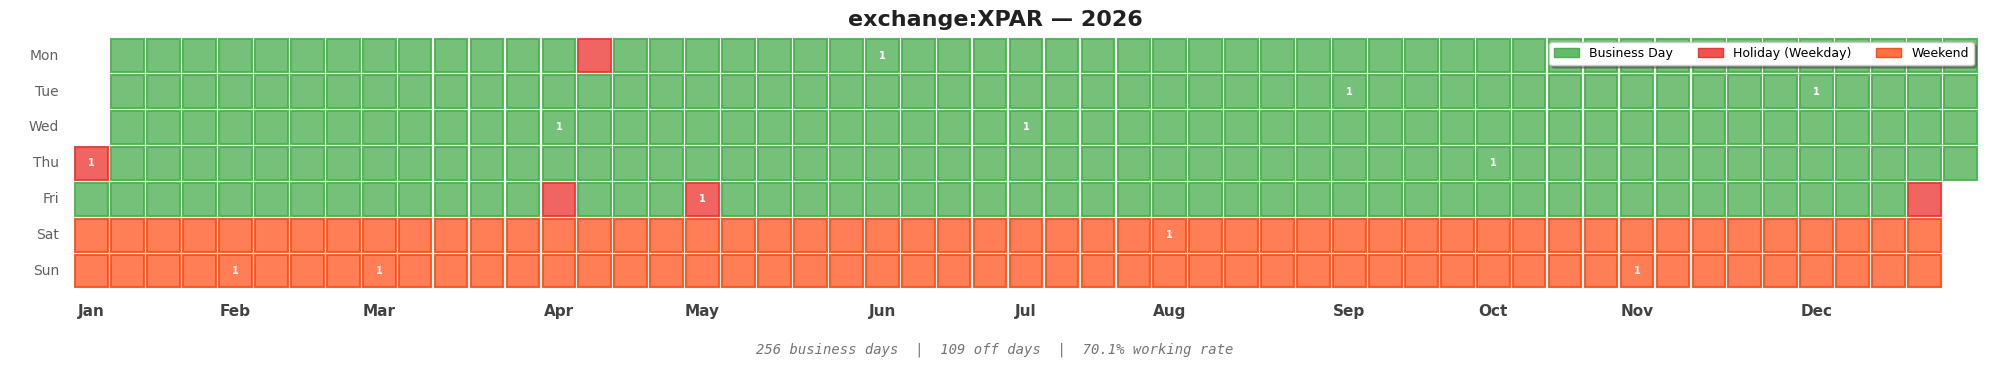

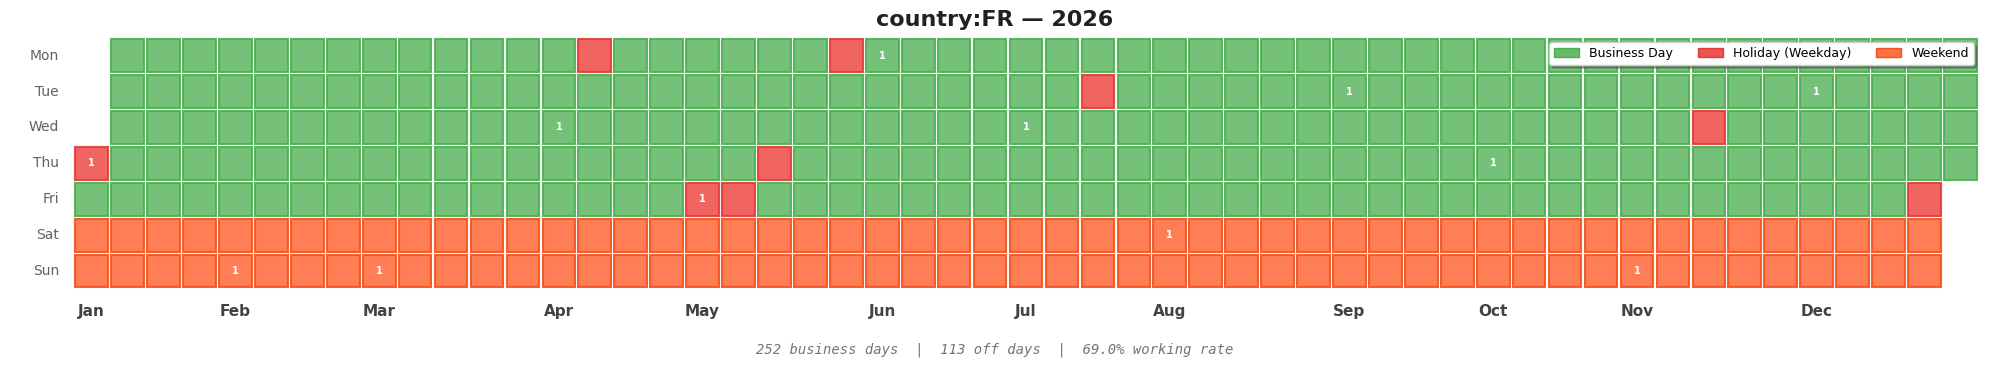

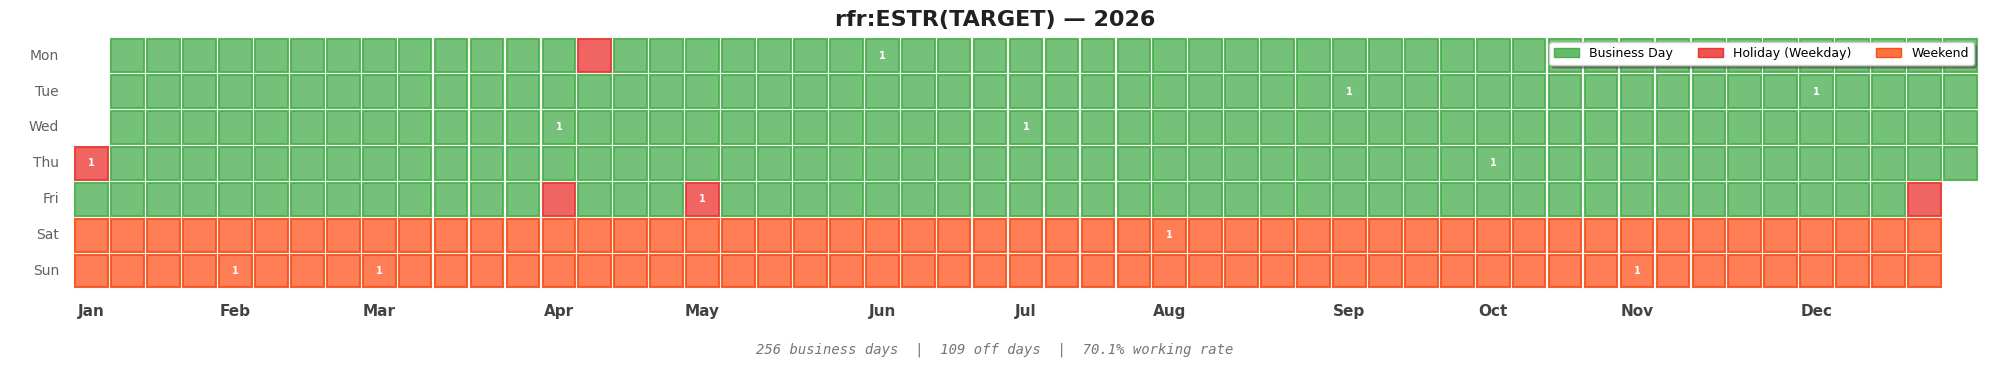

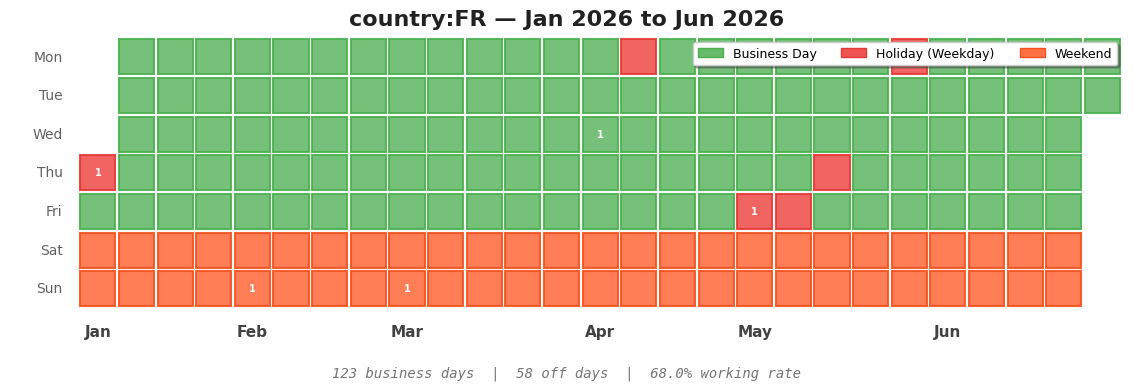

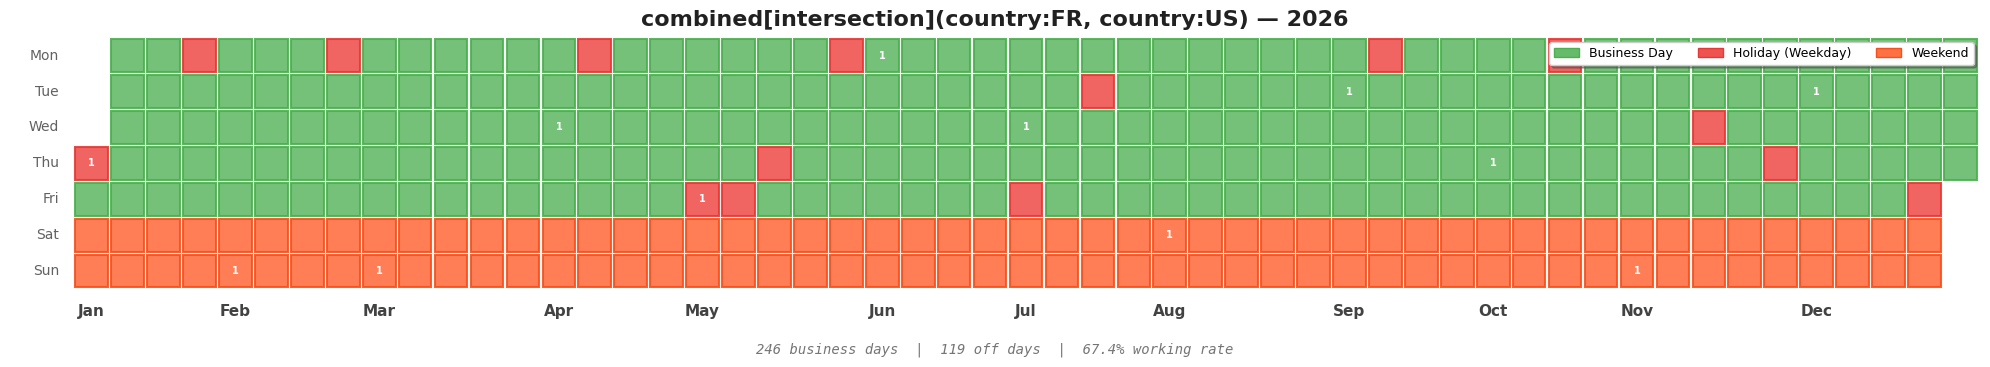

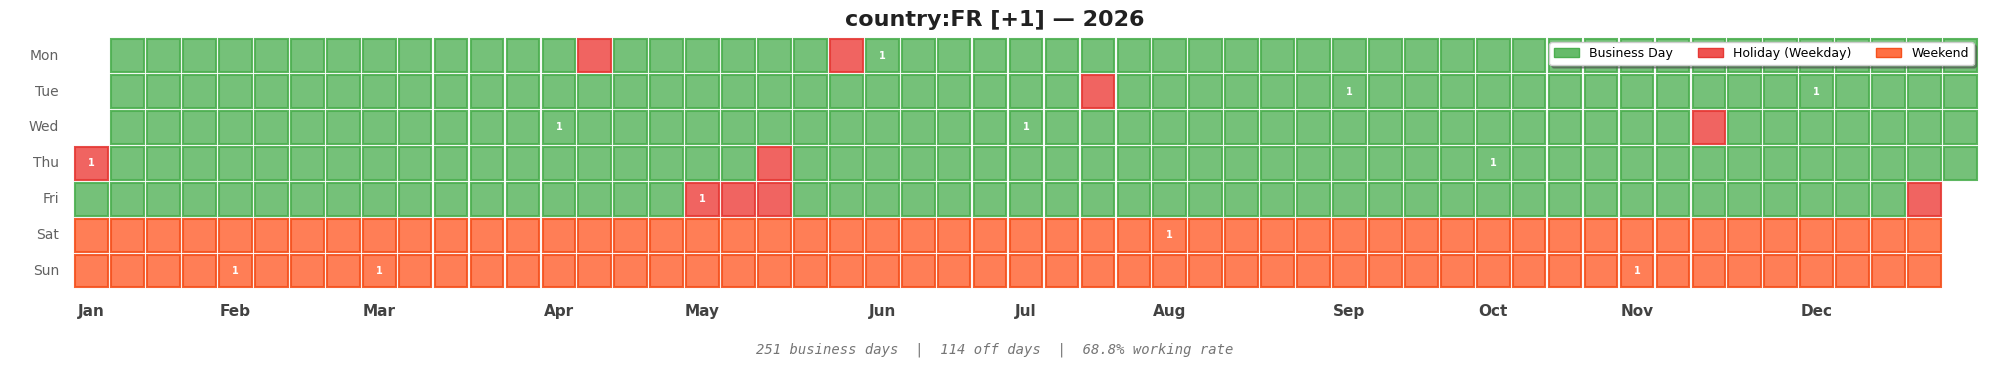

In [42]:
"""Test script for the new plot() functionality."""

from better_calendar import BetterCalendar
from datetime import date

# Initialize hub
hub = BetterCalendar.default()

# Test 1: Plot an exchange calendar
print("📊 Test 1: Generating plot for XPAR (Paris)...")
xpar = hub.get_from_exchange("XPAR")
fig, ax = xpar.plot(year=2026)
print("✓ XPAR plot generated successfully")

# Test 2: Plot a country calendar
print("\n📊 Test 2: Generating plot for FR (France)...")
fr = hub.get_from_country("FR")
fig2, ax2 = fr.plot(year=2026)
print("✓ FR plot generated successfully")

# Test 3: Plot an RFR calendar
print("\n📊 Test 3: Generating plot for €STR (TARGET)...")
estr = hub.get_from_rfr("ESTRON Index")
fig3, ax3 = estr.plot(year=2026)
print("✓ €STR plot generated successfully")

# Test 4: Plot with custom date range
print("\n📊 Test 4: Generating plot with custom date range...")
fig4, ax4 = fr.plot(start=date(2026, 1, 1), end=date(2026, 6, 30))
print("✓ Custom range plot generated successfully")

# Test 5: Plot a combined calendar
print("\n📊 Test 5: Generating plot for combined calendar (FR + US)...")
combined = hub.combine([
    ("country", "FR"),
    ("country", "US")
], mode="intersection")
fig5, ax5 = combined.plot(year=2026)
print("✓ Combined calendar plot generated successfully")

# Test 6: Plot with overrides
print("\n📊 Test 6: Generating plot with overrides...")
fr_custom = hub.with_overrides(
    "country", "FR",
    add_holidays=[date(2026, 5, 15)]  # Strike day
)
fig6, ax6 = fr_custom.plot(year=2026)
print("✓ Override calendar plot generated successfully")

print("\n✅ All plot tests passed!")
print("Note: Plots are generated but not displayed. Use plt.show() to display them.")
